In [89]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = "data.csv" # "resultados.csv"
df = pd.read_csv(path)

# Función para aplicar one-hot encoding y obtener variables
def get_variables(df, drop_first_category: bool = False):
    data = pd.get_dummies(df, columns=['herramienta'], drop_first=drop_first_category)
    X = data[['concurrency', 'vcpu', 'memory', 'volumen'] + [col for col in data.columns if 'herramienta_' in col]]
    y = data['capacidad_procesamiento']
    X = X.astype(float)
    y = y.astype(float)
    return X, y

def get_VIF(X):
    print("\nCalculate VIF values:")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

X,y = get_variables(df, True)
get_VIF(X)
X = X[[col for col in X.columns if not col in ['memory']]]
get_VIF(X)
# Añadir una constante a las variables independientes
X = sm.add_constant(X)
# Ajustar el modelo de regresión lineal
modelo = sm.OLS(y, X).fit()
# Mostrar el resumen del modelo
print(modelo.summary())


print("\nConvirtiendo la varaible y en logaritmica ->")

# Añadir una constante a las variables independientes
X = sm.add_constant(X)
y_log = np.log(y)
# Ajustar el modelo de regresión lineal
modelo = sm.OLS(y_log, X).fit()
# Mostrar el resumen del modelo
print(modelo.summary())

print("\nEscalando variables predictoras ->")

# Crear un escalador
scaler = StandardScaler()
# Aplicar el escalador solo a las variables numéricas (sin dummies)
X_scaled = X.copy()
numeric_cols = ["concurrency", "vcpu", "volumen"]  # Agrega otras variables numéricas si es necesario
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Ajustar el modelo GLS con los datos escalados
modelo_gls = sm.GLS(y_log, X_scaled).fit()

# Mostrar resultados
print(modelo_gls.summary())

print("\nConvirtiendo el volumen en logaritmico ->")
X_scaled = X_scaled.copy()
X_scaled["volumen_log"] = np.log(X_scaled["volumen"] + 1)
modelo_quad = sm.GLSAR(y_log, X_scaled, rho=1).iterative_fit()
print(modelo_quad.summary())

print("MODELO Gamma")
# Ajustar un modelo de regresión Gamma con link logarítmico
modelo_gamma = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log())).fit()

# Mostrar resultados
print(modelo_gamma.summary())

# Se intenta predecir la combinación de herramientas con concurrencia y volumen

X_int = X.copy()

# Identificar las columnas dummy de herramienta (suponiendo que 'apirest' es la referencia)
herramienta_cols = [col for col in X_int.columns if col.startswith("herramienta_")]

# Agregar interacciones: concurrency y volumen por cada dummy de herramienta
for col in herramienta_cols:
    X_int[f'concurrency_{col}'] = X_int['concurrency'] * X_int[col]
    X_int[f'volumen_{col}'] = X_int['volumen'] * X_int[col]

# Ahora, ajustamos el modelo Gamma con link logarítmico usando las variables con interacción
modelo_gamma_int = sm.GLM(y, X_int, family=sm.families.Gamma(link=sm.families.links.log())).fit()

# Mostrar el resumen del nuevo modelo
print(modelo_gamma_int.summary())

# Lista de herramientas presentes en el dataset
herramientas = df['herramienta'].unique()
print("Herramientas:", herramientas)

# Ajustar un modelo Gamma para cada herramienta
for herramienta in herramientas:
    print(f"\nAjustando modelo para {herramienta}...")
    df_tool = df[df['herramienta'] == herramienta].copy()
    
    # En este caso, como se ajusta un modelo por herramienta, no se requieren dummies
    # porque la categoría es homogénea
    X_tool = df_tool[['concurrency', 'vcpu',  'volumen']]
    X_tool["v2"] = X_tool["volumen"] ** 2
    X_tool["c2"] = X_tool["concurrency"] ** 2
    X_tool["carga"] = X_tool["volumen"] * X_tool["concurrency"]
    y_tool = df_tool['capacidad_procesamiento']
    
    # Eliminar 'memory' si se considera que introduce colinealidad
    
    # Agregar constante
    X_tool = sm.add_constant(X_tool)
    
    # Ajustar modelo Gamma con link log
    modelo_gamma_tool = sm.GLM(y_tool, X_tool, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    print(modelo_gamma_tool.summary())


Calculate VIF values:
                Variable       VIF
0            concurrency  2.343509
1                   vcpu       inf
2                 memory       inf
3                volumen  1.235745
4       herramienta_grpc  1.333520
5  herramienta_websocket  1.167461

Calculate VIF values:
                Variable       VIF
0            concurrency  2.343509
1                   vcpu  2.220902
2                volumen  1.235745
3       herramienta_grpc  1.333520
4  herramienta_websocket  1.167461
                               OLS Regression Results                              
Dep. Variable:     capacidad_procesamiento   R-squared:                       0.136
Model:                                 OLS   Adj. R-squared:                  0.136
Method:                      Least Squares   F-statistic:                     1161.
Date:                     Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                             01:07:04   Log-Likelihood:                -62

In [ ]:
path = "data/data.csv"
df = pd.read_csv(path)

def remove_outliers(df, cols, factor=1.5):
    """
    Elimina filas de df donde alguno de los valores en las columnas indicadas
    esté fuera del rango [Q1 - factor * IQR, Q3 + factor * IQR].
    """
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


# Ajustar un modelo Gamma para cada herramienta
for herramienta in df['herramienta'].unique():
    print(f"\nAjustando modelo para {herramienta}...")
    df_tool = df[df['herramienta'] == herramienta].copy()
    
    # Eliminar atípicos para las variables de interés
    # Aquí, por ejemplo, eliminamos outliers en 'concurrency', 'vcpu', 'volumen' y en la respuesta
    cols_to_check = ['concurrency', 'vcpu', 'volumen', 'capacidad_procesamiento']
    df_tool = remove_outliers(df_tool, cols_to_check, factor=1.5)
    print(df_tool[["vcpu", "memory"]].value_counts())
    
    # Definir variables predictoras y la respuesta
    X_tool = df_tool[['concurrency', 'vcpu', 'volumen']]
    # Agregar términos no lineales
    X_tool["v2"] = X_tool["volumen"] ** 2
    X_tool["c2"] = X_tool["concurrency"] ** 2
    X_tool["carga"] = X_tool["volumen"] * X_tool["concurrency"]
    y_tool = df_tool['capacidad_procesamiento']
    
    # Agregar constante
    X_tool = sm.add_constant(X_tool)
    
    # Ajustar modelo Gamma con link log
    modelo_gamma_tool = sm.GLM(y_tool, X_tool, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    print(modelo_gamma_tool.summary())



Ajustando modelo para apirest...
vcpu  memory
1.0   0.50      2994
2.0   1.00      2994
4.0   2.00      1996
0.5   0.25      1992
Name: count, dtype: int64
                    Generalized Linear Model Regression Results                    
Dep. Variable:     capacidad_procesamiento   No. Observations:                 9976
Model:                                 GLM   Df Residuals:                     9972
Model Family:                        Gamma   Df Model:                            3
Link Function:                         log   Scale:                         0.31873
Method:                               IRLS   Log-Likelihood:                 95531.
Date:                     Wed, 26 Feb 2025   Deviance:                       2247.3
Time:                             01:07:06   Pearson chi2:                 3.18e+03
No. Iterations:                         26   Pseudo R-squ. (CS):              1.000
Covariance Type:                 nonrobust                                         
   

                    Generalized Linear Model Regression Results                    
Dep. Variable:     capacidad_procesamiento   No. Observations:                36808
Model:                                 GLM   Df Residuals:                    36802
Model Family:                        Gamma   Df Model:                            5
Link Function:                         log   Scale:                          13.714
Method:                               IRLS   Log-Likelihood:             1.3533e+05
Date:                     Wed, 26 Feb 2025   Deviance:                   2.2886e+05
Time:                             01:07:07   Pearson chi2:                 5.05e+05
No. Iterations:                         80   Pseudo R-squ. (CS):             0.2954
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

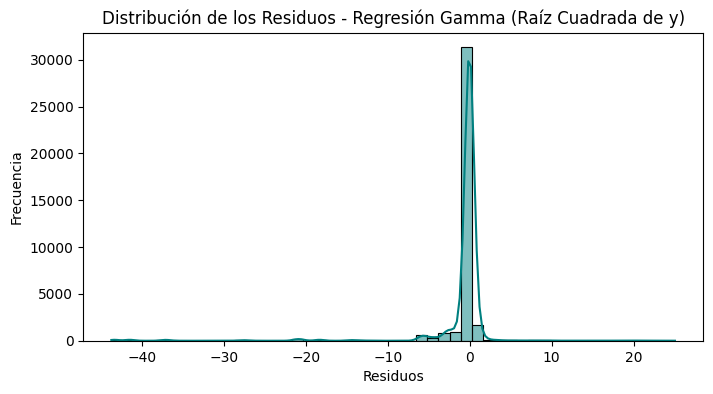

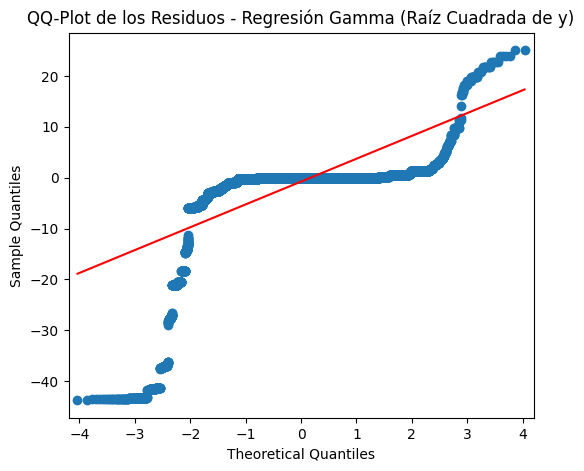

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar transformación de raíz cuadrada a la variable dependiente
y_sqrt = np.sqrt(y)

# Ajustar nuevamente la Regresión Gamma con enlace logarítmico sobre la variable transformada
modelo_gamma_sqrt = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log())).fit()

# Obtener residuos del nuevo modelo
residuos_gamma_sqrt = modelo_gamma_sqrt.resid_response

print(modelo_gamma_sqrt.summary())

# Graficar la distribución de los residuos
plt.figure(figsize=(8, 4))
sns.histplot(residuos_gamma_sqrt, bins=50, kde=True, color='teal')
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribución de los Residuos - Regresión Gamma (Raíz Cuadrada de y)")
plt.show()

# QQ-Plot para evaluar la normalidad de los residuos
plt.figure(figsize=(6, 5))
sm.qqplot(residuos_gamma_sqrt, line='s', ax=plt.gca(), color='teal')
plt.title("QQ-Plot de los Residuos - Regresión Gamma (Raíz Cuadrada de y)")
plt.show()




c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


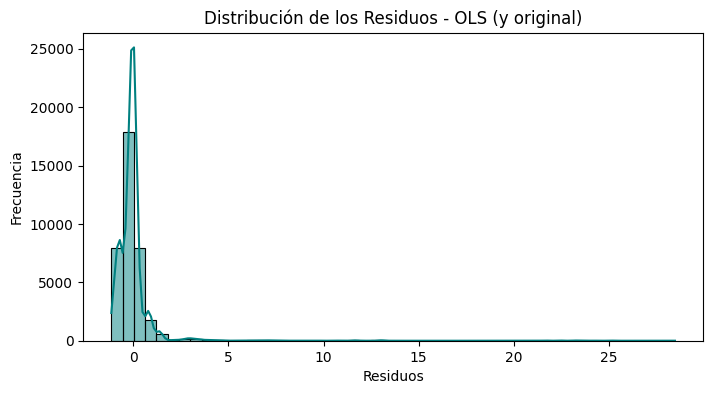

c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


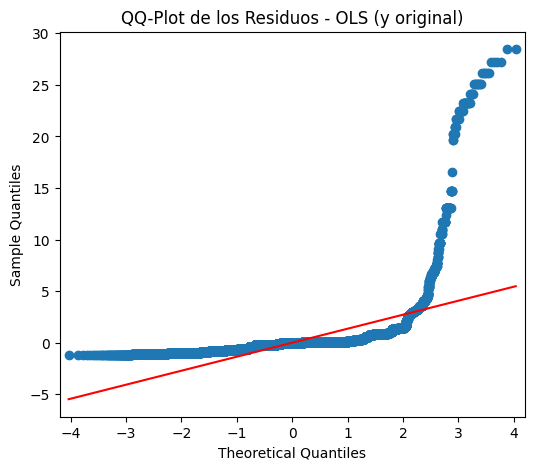

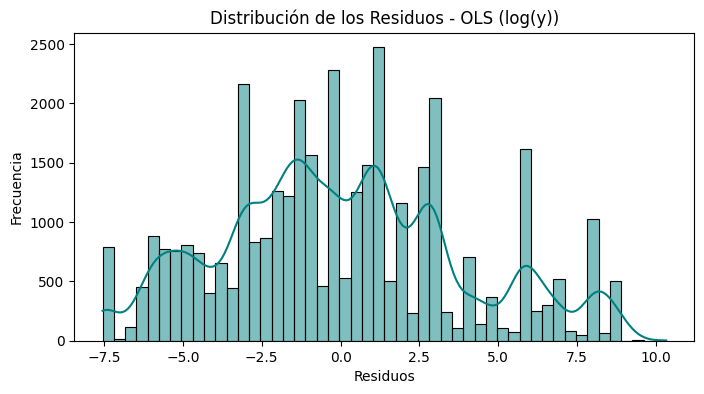

c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


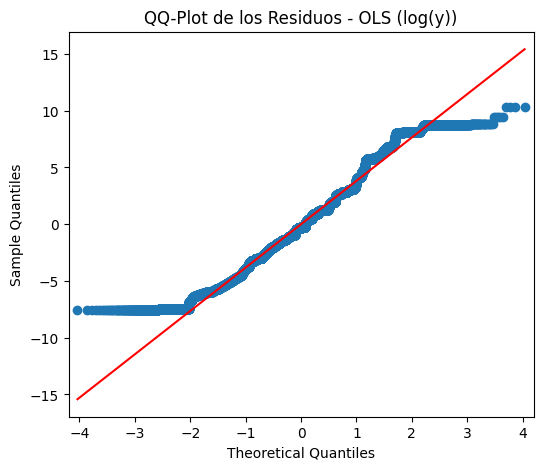

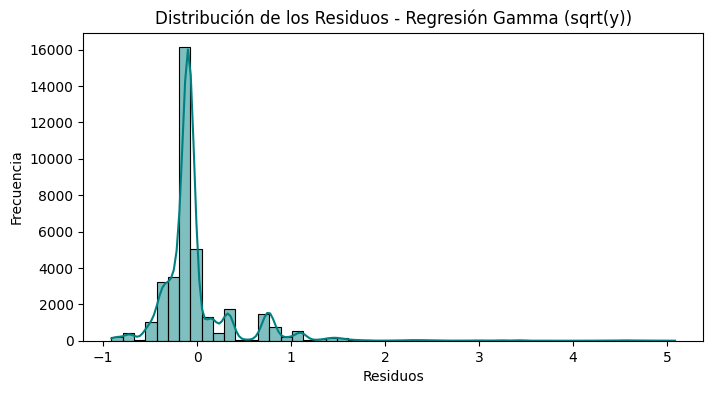

c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


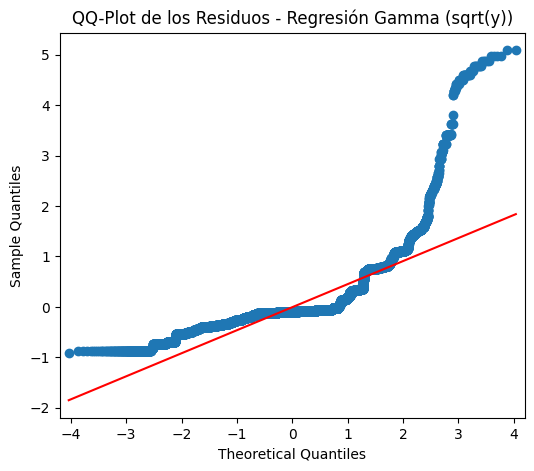

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# Cargar datos desde "data/data.csv"
path = "data/data.csv"
df = pd.read_csv(path)

# Seleccionar variables (ejemplo simplificado)
# Se asume que 'capacidad_procesamiento' es la variable respuesta
X = df[['concurrency', 'vcpu', 'volumen']]
X = sm.add_constant(X)
y = df['capacidad_procesamiento']

# --- Modelo 1: OLS con y original ---
model_ols = sm.OLS(y, X).fit()
res_ols = model_ols.resid

# --- Modelo 2: OLS con log(y) ---
y_log = np.log(y)
model_ols_log = sm.OLS(y_log, X).fit()
res_ols_log = model_ols_log.resid

# --- Modelo 3: Regresión Gamma con la variable transformada por raíz cuadrada ---
# Se transforma la variable dependiente para estabilizar la varianza
y_sqrt = np.sqrt(y)
model_gamma_sqrt = sm.GLM(y_sqrt, X, family=sm.families.Gamma(link=sm.families.links.log())).fit()
res_gamma_sqrt = model_gamma_sqrt.resid_response

def plot_model_residuals(residuals, title):
    # Histograma con KDE de los residuos
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=50, kde=True, color='teal')
    plt.xlabel("Residuos")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de los Residuos - " + title)
    plt.show()
    
    # QQ-Plot para evaluar la normalidad de los residuos
    plt.figure(figsize=(6, 5))
    sm.qqplot(residuals, line='s', ax=plt.gca(), color='teal')
    plt.title("QQ-Plot de los Residuos - " + title)
    plt.show()

# Graficar residuos de cada modelo
plot_model_residuals(res_ols, "OLS (y original)")
plot_model_residuals(res_ols_log, "OLS (log(y))")
plot_model_residuals(res_gamma_sqrt, "Regresión Gamma (sqrt(y))")


c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Devianza por fold: [57924.332545799334, 57491.057864904265, 57414.32584959104, 57663.072122405545, 56917.60941151525]
Devianza promedio (CV): 57482.07955884309


c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Factor de outlier 1.0: Número de observaciones = 17666, Devianza = 37527.38


c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Factor de outlier 1.5: Número de observaciones = 23001, Devianza = 54809.79


c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Factor de outlier 2.0: Número de observaciones = 23140, Devianza = 55274.57


c:\Users\johanmarin\AppData\Local\miniconda3\envs\rdt\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Factor de outlier 2.5: Número de observaciones = 23242, Devianza = 57857.33


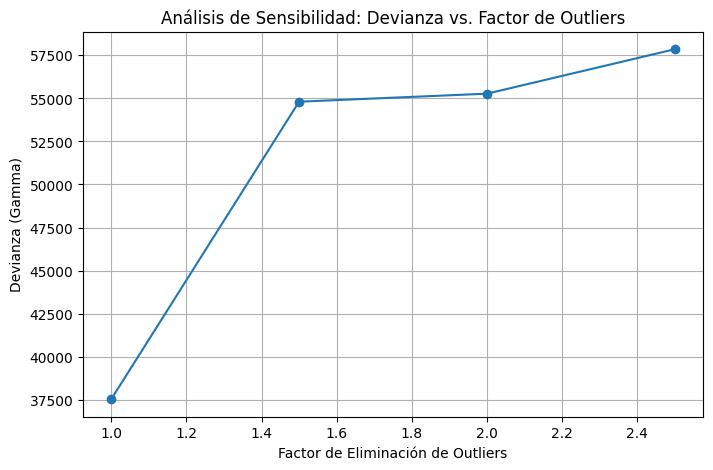

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
import scipy.stats as stats
import matplotlib.pyplot as plt

# Función para eliminar outliers (a nivel global, se puede adaptar para por grupo)
def remove_outliers(df, cols, factor=1.5):
    """
    Elimina filas de df donde alguno de los valores en las columnas indicadas
    esté fuera del rango [Q1 - factor*IQR, Q3 + factor*IQR].
    """
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Función para calcular la devianza para una distribución Gamma
def gamma_deviance(y_obs, y_pred):
    return 2 * np.sum((y_obs - y_pred) / y_pred - np.log(y_obs / y_pred))

# Función para ajustar un modelo GLM Gamma y calcular la devianza
def evaluate_model(X, y):
    model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    y_pred = model.predict(X)
    dev = gamma_deviance(y.values, y_pred)
    return model, dev

# Cargar datos
path = "data/data.csv"
df = pd.read_csv(path)

# Seleccionar variables predictoras y respuesta
X = df[['concurrency', 'vcpu', 'volumen']].copy()
# Agregar términos no lineales e interacción
X["v2"] = X["volumen"] ** 2
X["c2"] = X["concurrency"] ** 2
X["carga"] = X["volumen"] * X["concurrency"]
X = sm.add_constant(X)
y = df['capacidad_procesamiento']

# --- Validación Cruzada (5-Fold) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
deviances_cv = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model, dev = evaluate_model(X_train, y_train)
    # Predecir sobre el conjunto de test
    y_pred_test = model.predict(X_test)
    dev_test = gamma_deviance(y_test.values, y_pred_test)
    deviances_cv.append(dev_test)

print("Devianza por fold:", deviances_cv)
print("Devianza promedio (CV):", np.mean(deviances_cv))

# --- Análisis de Sensibilidad ---
# Se evalúa cómo afecta la eliminación de outliers variando el factor de corte.
factors = [1.0, 1.5, 2.0, 2.5]
dev_sensitivity = {}

cols_to_check = ['concurrency', 'vcpu', 'volumen', 'capacidad_procesamiento']

for f in factors:
    df_filtered = remove_outliers(df.copy(), cols_to_check, factor=f)
    X_filt = df_filtered[['concurrency', 'vcpu', 'volumen']].copy()
    X_filt["v2"] = X_filt["volumen"] ** 2
    X_filt["c2"] = X_filt["concurrency"] ** 2
    X_filt["carga"] = X_filt["volumen"] * X_filt["concurrency"]
    X_filt = sm.add_constant(X_filt)
    y_filt = df_filtered['capacidad_procesamiento']
    
    model_filt, dev_filt = evaluate_model(X_filt, y_filt)
    dev_sensitivity[f] = dev_filt
    print(f"Factor de outlier {f}: Número de observaciones = {len(df_filtered)}, Devianza = {dev_filt:.2f}")

# Graficar la sensibilidad de la devianza respecto al factor de eliminación de outliers
plt.figure(figsize=(8,5))
plt.plot(list(dev_sensitivity.keys()), list(dev_sensitivity.values()), marker='o')
plt.xlabel("Factor de Eliminación de Outliers")
plt.ylabel("Devianza (Gamma)")
plt.title("Análisis de Sensibilidad: Devianza vs. Factor de Outliers")
plt.grid(True)
plt.show()



In [3]:
import matplotlib
matplotlib.use("pgf")
import matplotlib.pyplot as plt

# Configurar matplotlib para usar LaTeX y la tipografía Computer Modern
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

# Datos de ejemplo: Factor de eliminación de outliers vs. Devianza (Gamma)
dev_sensitivity = {
    1.0: 37500,
    1.5: 57500,
    2.0: 57000,
    2.5: 57300
}

# Crear la figura
plt.figure(figsize=(8,5))
plt.plot(list(dev_sensitivity.keys()), list(dev_sensitivity.values()), marker='o', linestyle='-')
plt.xlabel(r"\textbf{Factor de Eliminación de Outliers}")
plt.ylabel(r"\textbf{Devianza (Gamma)}")
plt.title(r"\textbf{Análisis de Sensibilidad: Devianza vs. Factor de Outliers}")
plt.grid(True)

# Guardar la figura en formato PGF
plt.savefig("sensitivity_analysis.pgf")
plt.show()



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
C:\Users\johanmarin\AppData\Local\Temp\ipykernel_5380\2658072256.py:31: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()
